# Final Project Report
## Noam Siegel
### Physiological Signal Processing, Ben Gurion University
 #### 367-2-6351



In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from msc.config import get_config
from msc.dataset import RawDataset, PSPDataset
from msc.dataset.dataset import get_datasets_df
from scripts.psp.analysis.data_visualizations import plot_pca_projection
from scripts.psp.analysis.imshow_dataset import plot_feature_window
from scripts.psp.analysis.plot_feature_window import plot_results_score
from scripts.psp.build_dataset import build_dataset
from scripts.psp.training import classifier_comparison
from scripts.psp.analysis.plot_feature_window import plot_results_time


## Load configurations

In [10]:
config = get_config()
config

{'PATH': {'LOCAL': {'RAW_DATASET': 'C:\\raw_data\\epilepsiae',
   'RESULTS': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results',
   'PSP_DATASET': 'C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results\\epilepsiae'},
  'BGUCLUSTER': {'RAW_DATASET': '/cs_storage/noamsi/raw_data/epilepsiae/',
   'RESULTS': '/cs_storage/noamsi/results/',
   'PSP_DATASET': '/cs_storage/noamsi/results/epilepsiae/'},
  'MIRIAM': {'RAW_DATASET': '\\\\132.72.65.115\\epilepsy_data\\Epilepsiea\\raw_data'}},
 'TASK': {'PICKS': 'one_channel',
  'RESAMPLE': '256',
  'PREICTAL_MIN_DIFF_HOURS': '1',
  'INTERICTAL_MIN_DIFF_HOURS': '4',
  'PREICTAL_LABEL': '0',
  'INTERICTAL_LABEL': '1'},
 'RESULTS': {'LOCAL': None,
  'BGUCLUSTER': {'RESULTS_DIR': '/cs_storage/noamsi/results'}},
 'DATASET': 'epilepsiae',
 'RAW_MACHINE': 'MIRIAM',
 'RESULTS_MACHINE': 'LOCAL'}

## Get Raw dataset

In [11]:
raw_dataset = RawDataset(f"{config['PATH']['MIRIAM']['RAW_DATASET']}")
raw_dataset.data_df

,package,patient,admission,recording,fname,meas_date,end_date,time_zone,sfreq,nsamples,time_hours,nchan,ch_names,highpass,lowpass,fpath,seizure_table,num_seizures
0,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_018.data,2009-05-20 08:27:43,2009-05-20 08:34:56,UTC,400.0,173550,0.120521,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
1,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_012.data,2009-05-20 02:53:25,2009-05-20 03:49:08,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
2,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_010.data,2009-05-20 01:01:59,2009-05-20 01:57:42,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
3,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_004.data,2009-05-19 19:27:41,2009-05-19 20:23:24,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
4,surfPA,pat_1321103,adm_132110103,rec_13211010303,13211010303_003.data,2009-05-19 18:31:58,2009-05-19 19:27:41,UTC,400.0,1337200,0.928611,29,"['FT10', 'T10', 'TP10', 'F8', 'T4', 'T6', 'FP2...",0.0,200.0,/media/neurohelp/DATA/datasets/epilepsiae/surf...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17519,CO,pat_7800,adm_780100,rec_78010100,78010100_0057.data,2011-09-16 09:38:24,2011-09-16 11:38:24,UTC,1024.0,7372896,2.000026,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17520,CO,pat_7800,adm_780100,rec_78010100,78010100_0037.data,2011-09-15 05:55:27,2011-09-15 07:24:03,UTC,1024.0,5443712,1.476701,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,1
17521,CO,pat_7800,adm_780100,rec_78010100,78010100_0061.data,2011-09-16 16:18:40,2011-09-16 17:33:55,UTC,1024.0,4623808,1.254288,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0
17522,CO,pat_7800,adm_780100,rec_78010100,78010100_0042.data,2011-09-15 14:45:14,2011-09-15 15:20:22,UTC,1024.0,2159584,0.585825,32,"['FP1', 'AF7', 'FP2', 'F7', 'F3', 'FZ', 'F4', ...",0.0,512.0,/media/neurohelp/DATA/datasets/epilepsiae/CO/p...,/media/neurohelp/DATA/datasets/epilepsiae/seiz...,0


## Select random data file

In [12]:
data_row = raw_dataset.data_df.query("package == 'surfCO' and patient == 'pat_3500'").sample(1)
data_row.transpose()

,10659
package,surfCO
patient,pat_3500
admission,adm_350100
recording,rec_35010100
fname,35010100_0027.data
meas_date,2009-11-18 09:32:06
end_date,2009-11-18 09:57:40
time_zone,UTC
sfreq,1024.0
nsamples,1570976


## Plot raw data

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, AF7, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2009-11-18 09:32:06 UTC
 nchan: 32
 projs: []
 sfreq: 1024.0 Hz
>


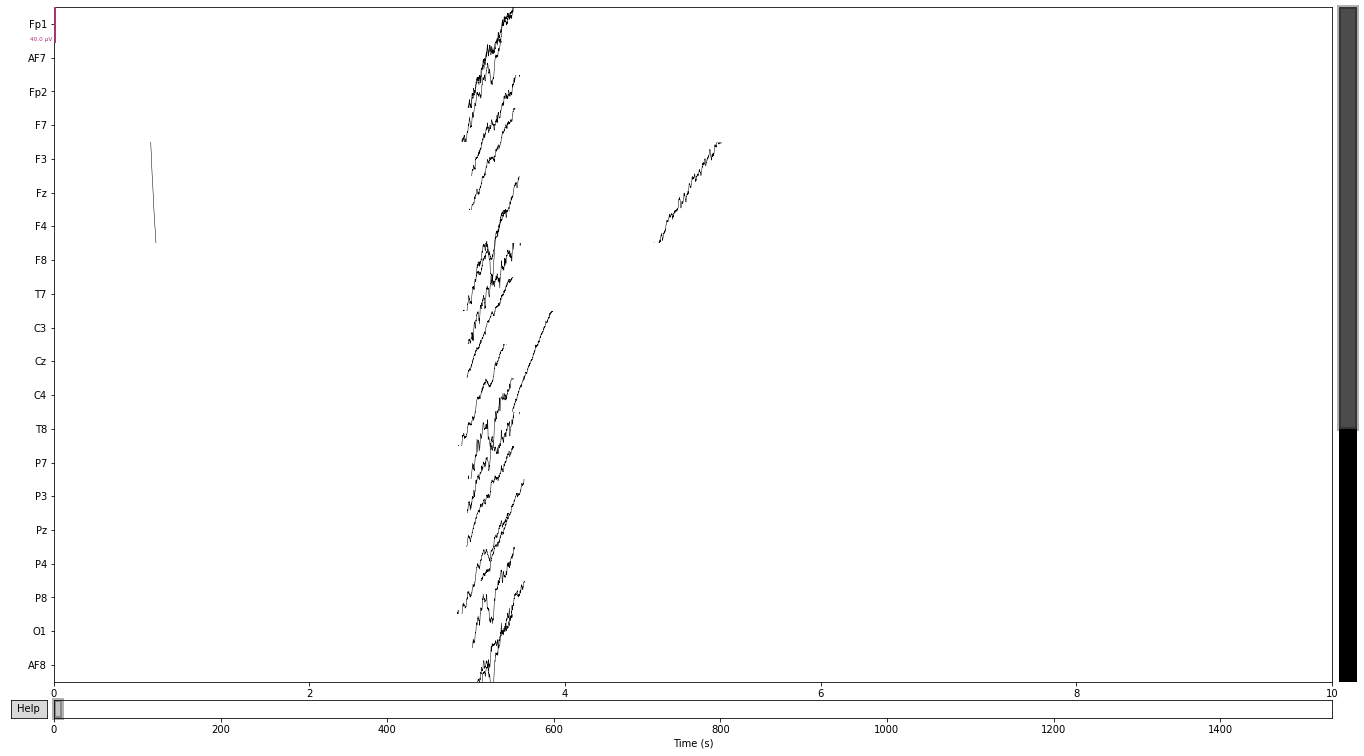

In [13]:
raw = raw_dataset.get_raw(data_row)
print(raw.info)
raw.plot();

## Feature Extraction
### Build Dataset (Demo)

In [14]:
available_features = ['max_cross_corr', 'phase_lock_val', 'nonlin_interdep', 'time_corr', 'spect_corr']
selected_feature = available_features[0]
package = 'surfCO'
selected_patient = 'pat_3500'

raw_args = ['--dev', '-p', selected_patient, '-f', selected_feature]

build_dataset.main(raw_args)

Starting build_dataset.py with fast_dev_mode=True at time 20211219T024058
WARNING! fast_dev_mode=True !!! Results are incomplete.
dumping results to C:\Users\noam\Repositories\noamsgl\msc\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058
getting selected_func='max_cross_corr' for patient='pat_3500' from package='surfCO'
len(preictal_intervals)=5
len(interictal_intervals)=6
len(preictal_window_intervals)=2
len(interictal_window_intervals)=2


loading patient data: 100%|██████████| 61/61 [01:07<00:00,  1.11s/it]


len(preictal_raws)=2
starting to extract features for preictal raws
dumping window_id=0 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_0.pkl'
dumping window_id=1 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_1.pkl'


loading patient data: 100%|██████████| 61/61 [01:52<00:00,  1.84s/it]


[<RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>, <RawNicolet | 35010100_0000.data, 19 x 76801 (300.0 s), ~11.2 MB, data loaded>]
starting to extract features for interictal raws
dumping window_id=2 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_2.pkl'
dumping window_id=3 to fname='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/window_3.pkl'
saving samples_df to samples_df_path='C:\\Users\\noam\\Repositories\\noamsgl\\msc\\results/epilepsiae/max_cross_corr/surfCO/pat_3500/20211219T024058/dataset.csv'


## Load index of existing datasets

In [15]:
datasets_df = get_datasets_df()
datasets_df

,feature_name,patient_name,data_dir
0,max_cross_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
1,max_cross_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
2,max_cross_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
3,phase_lock_val,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
4,phase_lock_val,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
5,phase_lock_val,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
6,spect_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...
7,spect_corr,pat_3700,C:\Users\noam\Repositories\noamsgl\msc\results...
8,spect_corr,pat_7200,C:\Users\noam\Repositories\noamsgl\msc\results...
9,time_corr,pat_3500,C:\Users\noam\Repositories\noamsgl\msc\results...


## Visualize Features
Assumes many datasets have been built

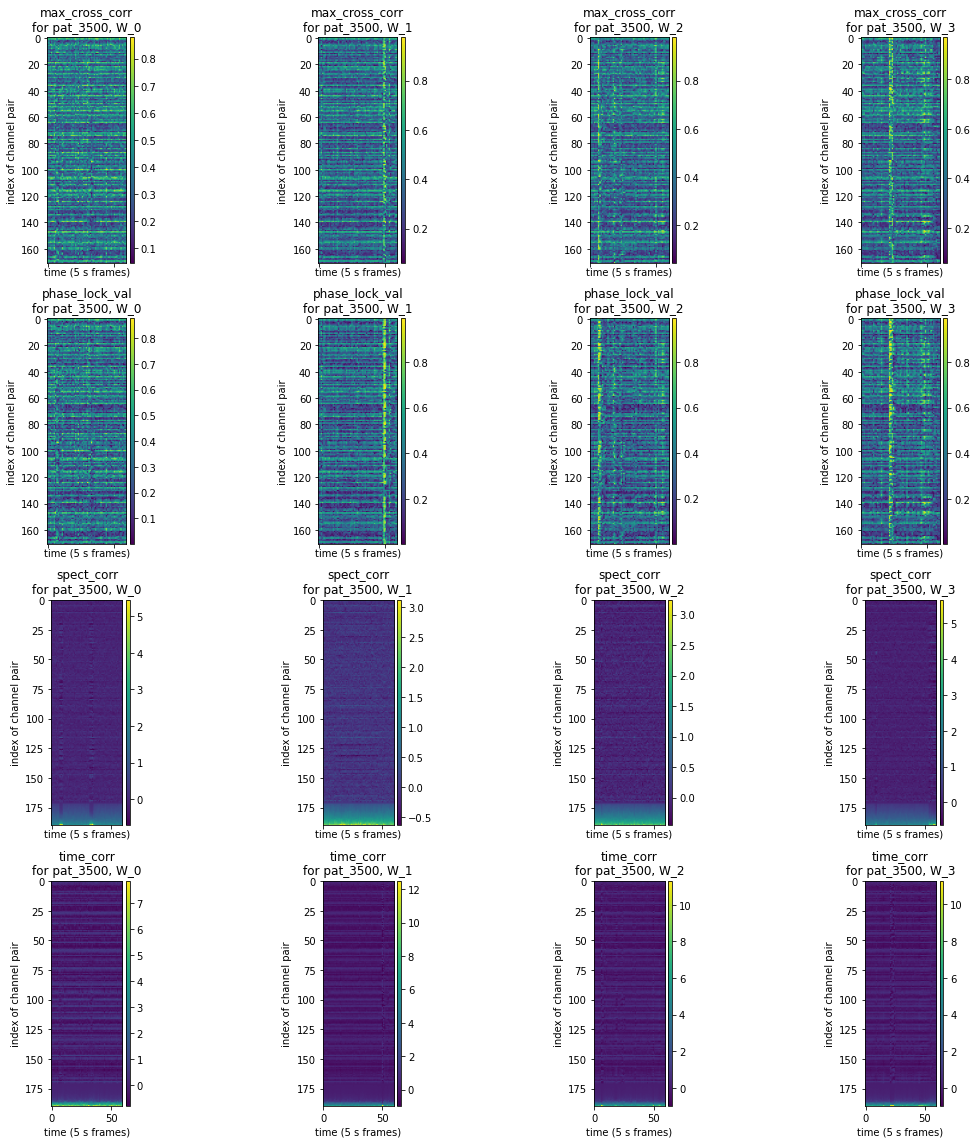

In [17]:
patients_datasets_df = datasets_df.query(f"patient_name == '{selected_patient}'").reset_index()
nrows = len(patients_datasets_df)
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * nrows, 4 * ncols), sharex=True, sharey=False)
for i in range(nrows):
    dataset = patients_datasets_df.loc[i]
    psp_dataset = PSPDataset(dataset.data_dir)
    X, labels = psp_dataset.get_X(), psp_dataset.get_labels(format='desc')
    for j in range(ncols):
        plot_feature_window(X[j].reshape(-1, 60), patient_name=selected_patient, window_name=f'W_{j}', feature_name=dataset.feature_name, ax=axes[i, j])
plt.tight_layout()
plt.show()


## Visualize Datasets
We show a PCA projection to 2 dimensions for 12 different datasets.

plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 1, dtype: object
plotting pca for feature_name                                       max_cross_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 2, dtype: object
plotting pca for feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object
plotting pca for feature_name                   

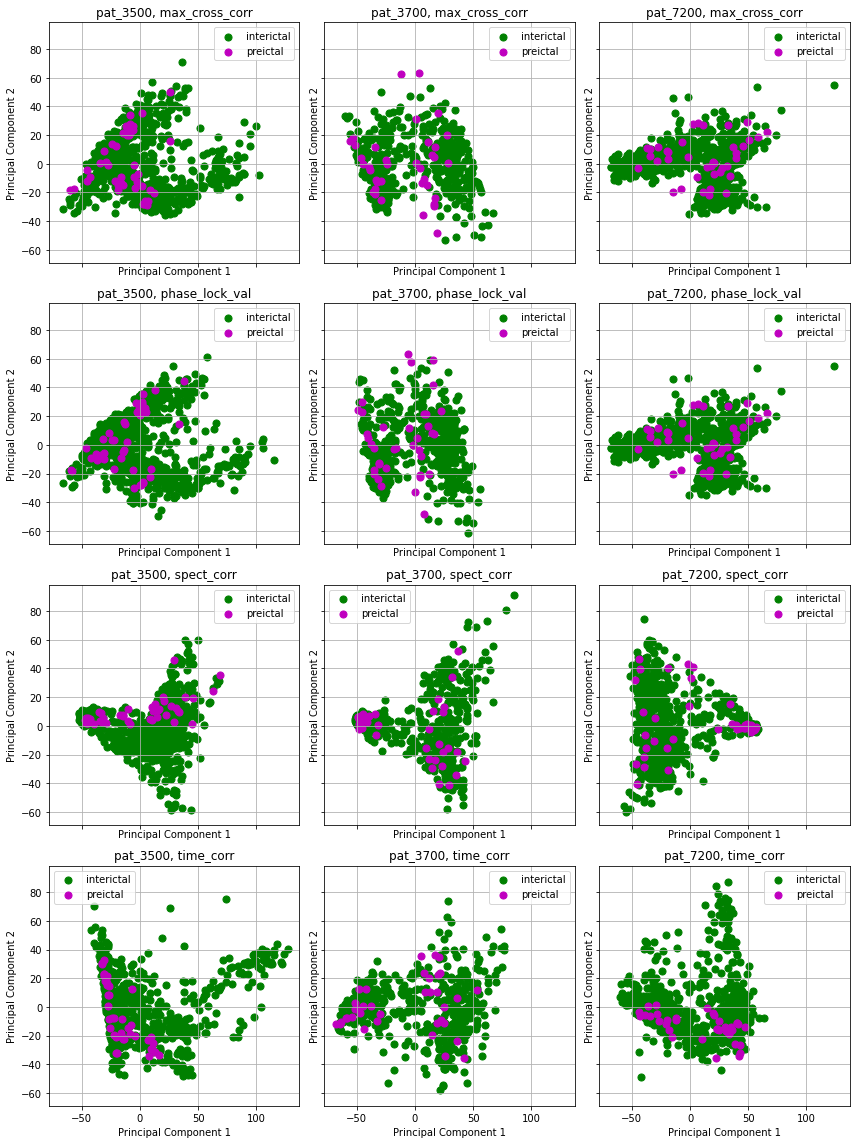

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(12, 16), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    plot_pca_projection(datasets_df.sort_values(by=['feature_name', 'patient_name'], ignore_index=True).loc[i], ax=ax)
plt.tight_layout()
plt.show()


## Train classifier on multiple feature datasets at once

In [19]:
feature_names = (
    'max_cross_corr',
    'phase_lock_val',
    'spect_corr',
    'time_corr'
)

patient_names = ['pat_3500',
                 'pat_3700',
                 'pat_7200'
                 ]

classifier_names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
results = classifier_comparison.main(save_to_disk=False,
                                     feature_names=feature_names,
                                     patient_names=patient_names,
                                     classifier_names=classifier_names)

iterating datasets:   0%|          | 0/12 [00:00<?, ?it/s]

beginning ds=feature_name                                       max_cross_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 0, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:16<00:39, 39.06s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                       max_cross_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 1, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [03:49<00:30, 30.90s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                       max_cross_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 2, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:29<00:40, 40.99s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                       phase_lock_val
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 3, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:38<00:42, 42.43s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                       phase_lock_val
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 4, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [03:51<00:31, 31.82s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                       phase_lock_val
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 5, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:40<00:42, 42.41s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                           spect_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 6, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:45<00:43, 43.36s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                           spect_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 7, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [04:23<00:36, 36.47s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                           spect_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 8, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [06:10<00:46, 46.48s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                            time_corr
patient_name                                             pat_3500
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 9, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:50<00:45, 45.78s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                            time_corr
patient_name                                             pat_3700
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 10, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [04:36<00:39, 39.30s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

beginning ds=feature_name                                            time_corr
patient_name                                             pat_7200
data_dir        C:\Users\noam\Repositories\noamsgl\msc\results...
Name: 11, dtype: object



iterating over classifiers:  89%|████████▉ | 8/9 [05:43<00:44, 44.11s/it]C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\si

In [20]:
results = results.set_index(['patient_name','feature_name','classifier_name'])
results

fold  fit_time  score_time  \
patient_name feature_name   classifier_name                                 
pat_3500     max_cross_corr Nearest Neighbors     0  0.009007    0.029949   
                            Nearest Neighbors     1  0.009052    0.024987   
                            Nearest Neighbors     2  0.008017    0.023984   
                            Nearest Neighbors     3  0.008016    0.023985   
                            Nearest Neighbors     4  0.008025    0.024949   
...                                             ...       ...         ...   
pat_7200     time_corr      QDA                   0  0.578084    0.033984   
                            QDA                   1  0.599321    0.035982   
                            QDA                   2  0.594086    0.037982   
                            QDA                   3  0.607116    0.037038   
                            QDA                   4  0.638007    0.034977   

                                                                         estimator  \
patient_name feature_name   classifier_name                                          
pat_3500     max_cross_corr Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
                            Nearest Neighbors  KNeighborsClassifier(n_neighbors=3)   
...                                                                            ...   
pat_7200     time_corr      QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   
                            QDA                    QuadraticDiscriminantAnalysis()   

                                               test_precision  test_recall  \
patient_name feature_name   classifier_name                                  
pat_3500     max_cross_corr Nearest Neighbors        0.951613     0.967213   
                            Nearest Neighbors        0.966102     0.934426   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.953125     1.000000   
                            Nearest Neighbors        0.949153     0.918033   
...                                                       ...          ...   
pat_7200     time_corr      QDA                      0.916667     0.180328   
                            QDA                      0.937500     0.245902   
                            QDA                      1.000000     0.344262   
                            QDA                      0.866667     0.216667   
                            QDA                      1.000000     0.283333   

                                               test_roc_auc  \
patient_name feature_name   classifier_name                   
pat_3500     max_cross_corr Nearest Neighbors      0.577869   
                            Nearest Neighbors      0.568306   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.751366   
                            Nearest Neighbors      0.385246   
...                                                     ...   
pat_7200     time_corr      QDA                    0.300546   
                            QDA                    0.377049   
                            QDA                    0.770492   
                            QDA                    0.300000   
                            QDA                    0.838889   

                                                                                        dat

In [23]:
results.groupby(['patient_name','feature_name','classifier_name']).mean().drop(columns='fold').add_suffix('_mean')

fit_time_mean  score_time_mean  \
patient_name feature_name   classifier_name                                     
pat_3500     max_cross_corr AdaBoost               10.538184         0.175015   
                            Decision Tree           0.711377         0.005984   
                            Linear SVM              5.959221         2.080417   
                            Naive Bayes             0.039996         0.025189   
                            Nearest Neighbors       0.008423         0.025571   
...                                                      ...              ...   
pat_7200     time_corr      Nearest Neighbors       0.010207         0.029009   
                            Neural Net             20.458914         0.009195   
                            QDA                     0.603323         0.035993   
                            RBF SVM                 7.410460         4.101780   
                            Random Forest           0.024383         0.007615   

                                               test_precision_mean  \
patient_name feature_name   classifier_name                          
pat_3500     max_cross_corr AdaBoost                      0.950192   
                            Decision Tree                 0.949398   
                            Linear SVM                    0.950192   
                            Naive Bayes                   0.947160   
                            Nearest Neighbors             0.954623   
...                                                            ...   
pat_7200     time_corr      Nearest Neighbors             0.959975   
                            Neural Net                    0.955146   
                            QDA                           0.944167   
                            RBF SVM                       0.955853   
                            Random Forest                 0.955853   

                                               test_recall_mean  \
patient_name feature_name   classifier_name                       
pat_3500     max_cross_corr AdaBoost                   1.000000   
                            Decision Tree              0.924590   
                            Linear SVM                 1.000000   
                            Naive Bayes                0.872131   
                            Nearest Neighbors          0.963934   
...                                                         ...   
pat_7200     time_corr      Nearest Neighbors          0.934153   
                            Neural Net                 0.983552   
                            QDA                        0.254098   
                            RBF SVM                    1.000000   
                            Random Forest              1.000000   

                                               test_roc_auc_mean  
patient_name feature_name   classifier_name                       
pat_3500     max_cross_corr AdaBoost                    0.497541  
                            Decision Tree               0.487295  
                            Linear SVM                  0.825956  
                            Naive Bayes                 0.487978  
                            Nearest Neighbors           0.606831  
...                                                          ...  
pat_7200     time_corr      Nearest Neighbors           0.640328  
                            Neural Net                  0.560383  
                            QDA                         0.517395  
                            RBF SVM                     0.500000  
                            Random Forest               0.489563  

[108 rows x 5 columns]

In [26]:
results.groupby(['patient_name','feature_name','classifier_name']).std().drop(columns='fold').add_suffix('_std')

fit_time_std  score_time_std  \
patient_name feature_name   classifier_name                                   
pat_3500     max_cross_corr AdaBoost               0.365358        0.003991   
                            Decision Tree          0.160673        0.000708   
                            Linear SVM             0.256505        0.053760   
                            Naive Bayes            0.005701        0.001919   
                            Nearest Neighbors      0.000554        0.002497   
...                                                     ...             ...   
pat_7200     time_corr      Nearest Neighbors      0.001778        0.001439   
                            Neural Net             1.403211        0.000432   
                            QDA                    0.022112        0.001590   
                            RBF SVM                0.301968        0.147475   
                            Random Forest          0.000563        0.000559   

                                               test_precision_std  \
patient_name feature_name   classifier_name                         
pat_3500     max_cross_corr AdaBoost                     0.006558   
                            Decision Tree                0.002512   
                            Linear SVM                   0.006558   
                            Naive Bayes                  0.007856   
                            Nearest Neighbors            0.006619   
...                                                           ...   
pat_7200     time_corr      Nearest Neighbors            0.013544   
                            Neural Net                   0.007052   
                            QDA                          0.057100   
                            RBF SVM                      0.006942   
                            Random Forest                0.006942   

                                               test_recall_std  \
patient_name feature_name   classifier_name                      
pat_3500     max_cross_corr AdaBoost                  0.000000   
                            Decision Tree             0.047229   
                            Linear SVM                0.000000   
                            Naive Bayes               0.078106   
                            Nearest Neighbors         0.037383   
...                                                        ...   
pat_7200     time_corr      Nearest Neighbors         0.070593   
                            Neural Net                0.011593   
                            QDA                       0.063037   
                            RBF SVM                   0.000000   
                            Random Forest             0.000000   

                                               test_roc_auc_std  
patient_name feature_name   classifier_name                      
pat_3500     max_cross_corr AdaBoost                   0.132423  
                            Decision Tree              0.058972  
                            Linear SVM                 0.117865  
                            Naive Bayes                0.066016  
                            Nearest Neighbors          0.152646  
...                                                         ...  
pat_7200     time_corr      Nearest Neighbors          0.223370  
                            Neural Net                 0.177893  
                            QDA                        0.265234  
                            RBF SVM                    0.000000  
                            Random Forest              0.163122  

[108 rows x 5 columns]

## Evaluation metrics for different classifiers
In each metric, the bars show the mean score per classifier on 5-fold cross validation, and the black line is the standard deviation error bar.
In terms of precision alone, all the classifiers are quite precise. The recall of the QDA classifier is

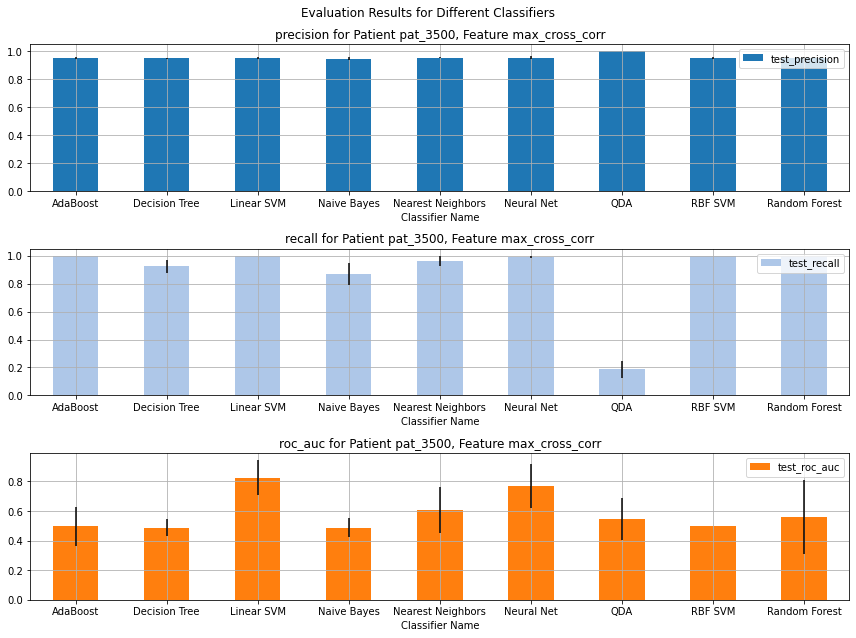

In [41]:
fig, axes = plt.subplots(3, figsize=(12, 9), sharex=False)
patient_results = results.loc[selected_patient, selected_feature, :].reset_index()

cs = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5']

colors = itertools.cycle(cs)
fig.suptitle('Evaluation Results for Different Classifiers')
for i, score in enumerate(('precision', 'recall', 'roc_auc')):
    plot_results_score(patient_results, patient_name=selected_patient, feature_name=selected_feature, score=score, ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

## Evaluate single classifier
We saw that the Linear SVM gave the highest overall ROC AUC score. Let's go ahead and plot it's ROC curve.

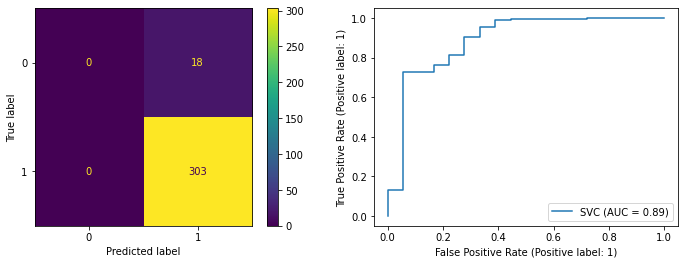

In [50]:
dataset = patients_datasets_df.query(f"feature_name == '{selected_feature}' and patient_name == '{selected_patient}'")
psp_dataset = PSPDataset(dataset.data_dir.item())

estimator = results.loc['pat_3500', 'max_cross_corr', 'Linear SVM', results['fold'] == 0].estimator.item()
X, labels = psp_dataset.get_X(), psp_dataset.get_labels()
le = LabelEncoder()
le.fit(labels)

X_train, X_test, y_train, y_test = train_test_split(
    X, le.transform(labels), test_size=0.4, random_state=0)
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test, ax=axes[0])
RocCurveDisplay.from_estimator(estimator, X_test, y_test, ax=axes[1])

## Running times for classifiers
Unsurprisingly, the neural network variations (MLPClassifier, SVMs) and the ensemble method, Adaboost took the most time to fit. Also somewhat surprising, is that the score times of the SVMs (on the test set) took even longer than the fit time (on the training set).

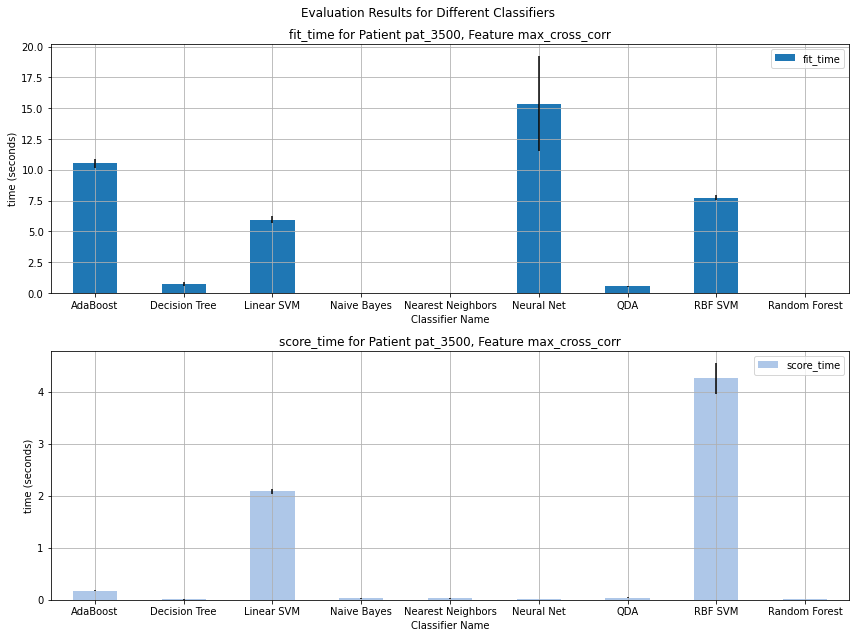

In [42]:
fig, axes = plt.subplots(2, figsize=(12, 9), sharex=False)

colors = itertools.cycle(cs)

fig.suptitle('Evaluation Results for Different Classifiers')
for i, time_col in enumerate(('fit_time', 'score_time')):
    plot_results_time(patient_results, patient_name=selected_patient, feature_name=selected_feature, time_col=time_col, ax=axes[i], logy=False, color=next(colors))
plt.tight_layout()

## Feature Selection
For feature selection, we will use the Recursive Feature Elimination algorithm to find a subset of features which balances optimally between minimal set size and maximal objective function.

In [51]:

estimator

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

In [52]:
estimator = results.loc['pat_3500', 'max_cross_corr', 'Random Forest', results['fold'] == 0].estimator.item()
selector = RFE(estimator, n_features_to_select=60 * 10)
selector = selector.fit(X, labels)

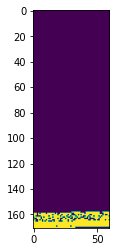

In [53]:
plt.imshow(selector.support_.reshape(-1,60))